# Trabalho Final de Inteligência Artificial

### Objetivo: 
- Desenvolver uma aplicação utilizando Redes Neurais Convolucionais (CNN) para resolver um problema de classificação binária ou multiclasse, implementando e comparando versões arquiteturais e explorando fundamentos técnicos da modelagem e treinamento.

## Download do dataset e Importação de bibliotecas

In [1]:
import os
from PIL import Image
import tensorflow as tf
import pandas as pd
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tensorflow.keras.applications import (
    vgg16,
    VGG16,
    mobilenet_v2,
    efficientnet,
    EfficientNetB0,
    resnet50
)
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation,
    MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

## 1. Dataset e definição do problema
- O problema a ser resolvido é a classificação de imagens multiclasse. O objetivo é desenvolver um sistema que, ao receber uma imagem de um Pokémon como entrada, seja capaz de identificar e classificar corretamente a qual "tipo" ele pertence (ex: Fogo, Água, Planta, Elétrico, etc.).

> Entrada (Input): Uma imagem contendo um Pokémon.

> Saída (Output): Um rótulo de classe que corresponde ao tipo do Pokémon na imagem.

- As CNNs são o estado da arte para tarefas de visão computacional. Sua arquitetura é inspirada no córtex visual humano e é projetada especificamente para processar dados que possuem uma grade espacial, como as imagens. Elas são capazes de aprender e extrair características visuais de forma automática e hierárquica.
- Diferente de métodos mais antigos, não precisamos extrair características manualmente (ex: "se a cor predominante é azul, talvez seja do tipo Água"). A CNN aprende sozinha quais características são importantes.
  - Camadas Iniciais: Aprendem a detectar características simples, como bordas, cantos, texturas e cores.

  - Camadas Intermediárias: Combinam essas características simples para formar padrões mais complexos, como olhos, asas, caudas ou padrões de pele.

  - Camadas Finais: Usam esses padrões complexos para realizar a classificação final, identificando o Pokémon e, consequentemente, seu tipo.
- Os Pokémon no dataset podem aparecer em diferentes poses, iluminações, estilos de arte e com fundos variados. As CNNs, especialmente quando combinadas com técnicas de aumento de dados (Data Augmentation), como rotações, zooms e espelhamentos, tornam-se robustas a essas variações, melhorando a capacidade de generalização do modelo para imagens nunca vistas antes.
- O requisito do trabalho de "comparar versões arquiteturais" é atendido pelas CNNs. É possível explorar e comparar facilmente o impacto de:

   - Profundidade: Aumentar ou diminuir o número de camadas convolucionais.

   - Largura: Alterar o número de filtros (neurônios) em cada camada.

   - Componentes: Trocar funções de ativação (ReLU, Leaky ReLU), otimizadores (Adam, SGD) ou usar técnicas de regularização (Dropout, Batch Normalization).

- Em termos práticos, treinar uma CNN para reconhecer o “Type1” a partir da arte do Pokémon poderia automatizar tarefas críticas de curadoria, detecção de fraudes e criação de ferramentas inteligentes para o ecossistema de vários contextos em que o IP Pokémon é usado.

In [2]:
csv_path = "data/pokemon/pokemon.csv"
df = pd.read_csv(csv_path)
df_gen1 = df.iloc[0:151].reset_index(drop=True)

/tmp/ipykernel_121748/3121761056.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_gen1['Type1'], order=type1_order, palette='viridis')


Gráfico 'distribuicao_tipo1.png' salvo com sucesso!


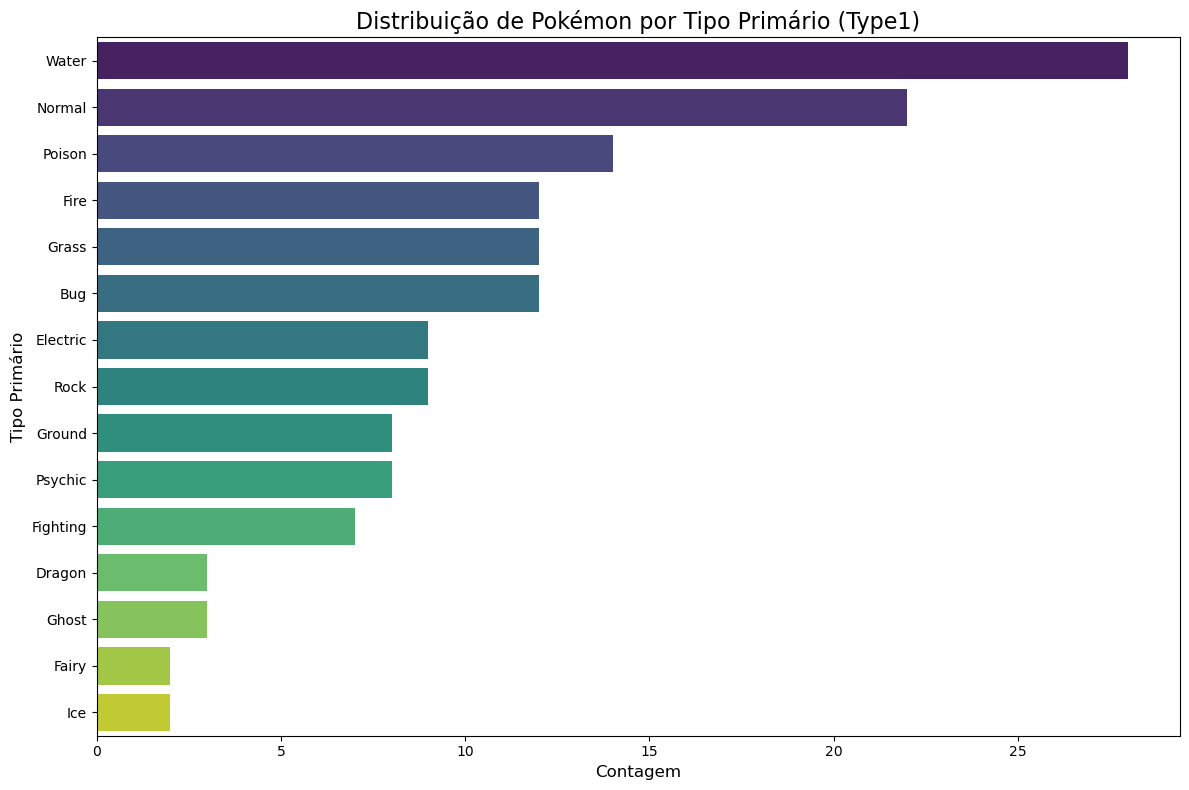

In [3]:
# --- Gráfico 1: Distribuição de Tipos Primários (Type1) ---
# Os tipos que iremos focar nesse trabalho
plt.figure(figsize=[12, 8])
type1_order = df_gen1['Type1'].value_counts().index
sns.countplot(y=df_gen1['Type1'], order=type1_order, palette='viridis')
plt.title('Distribuição de Pokémon por Tipo Primário (Type1)', fontsize=16)
plt.xlabel('Contagem', fontsize=12)
plt.ylabel('Tipo Primário', fontsize=12)
plt.tight_layout()
plt.savefig('distribuicao_tipo1.png')
print("Gráfico 'distribuicao_tipo1.png' salvo com sucesso!")

In [4]:
# melhorar resolução da imagem
%config InlineBackend.figure_format = 'retina'

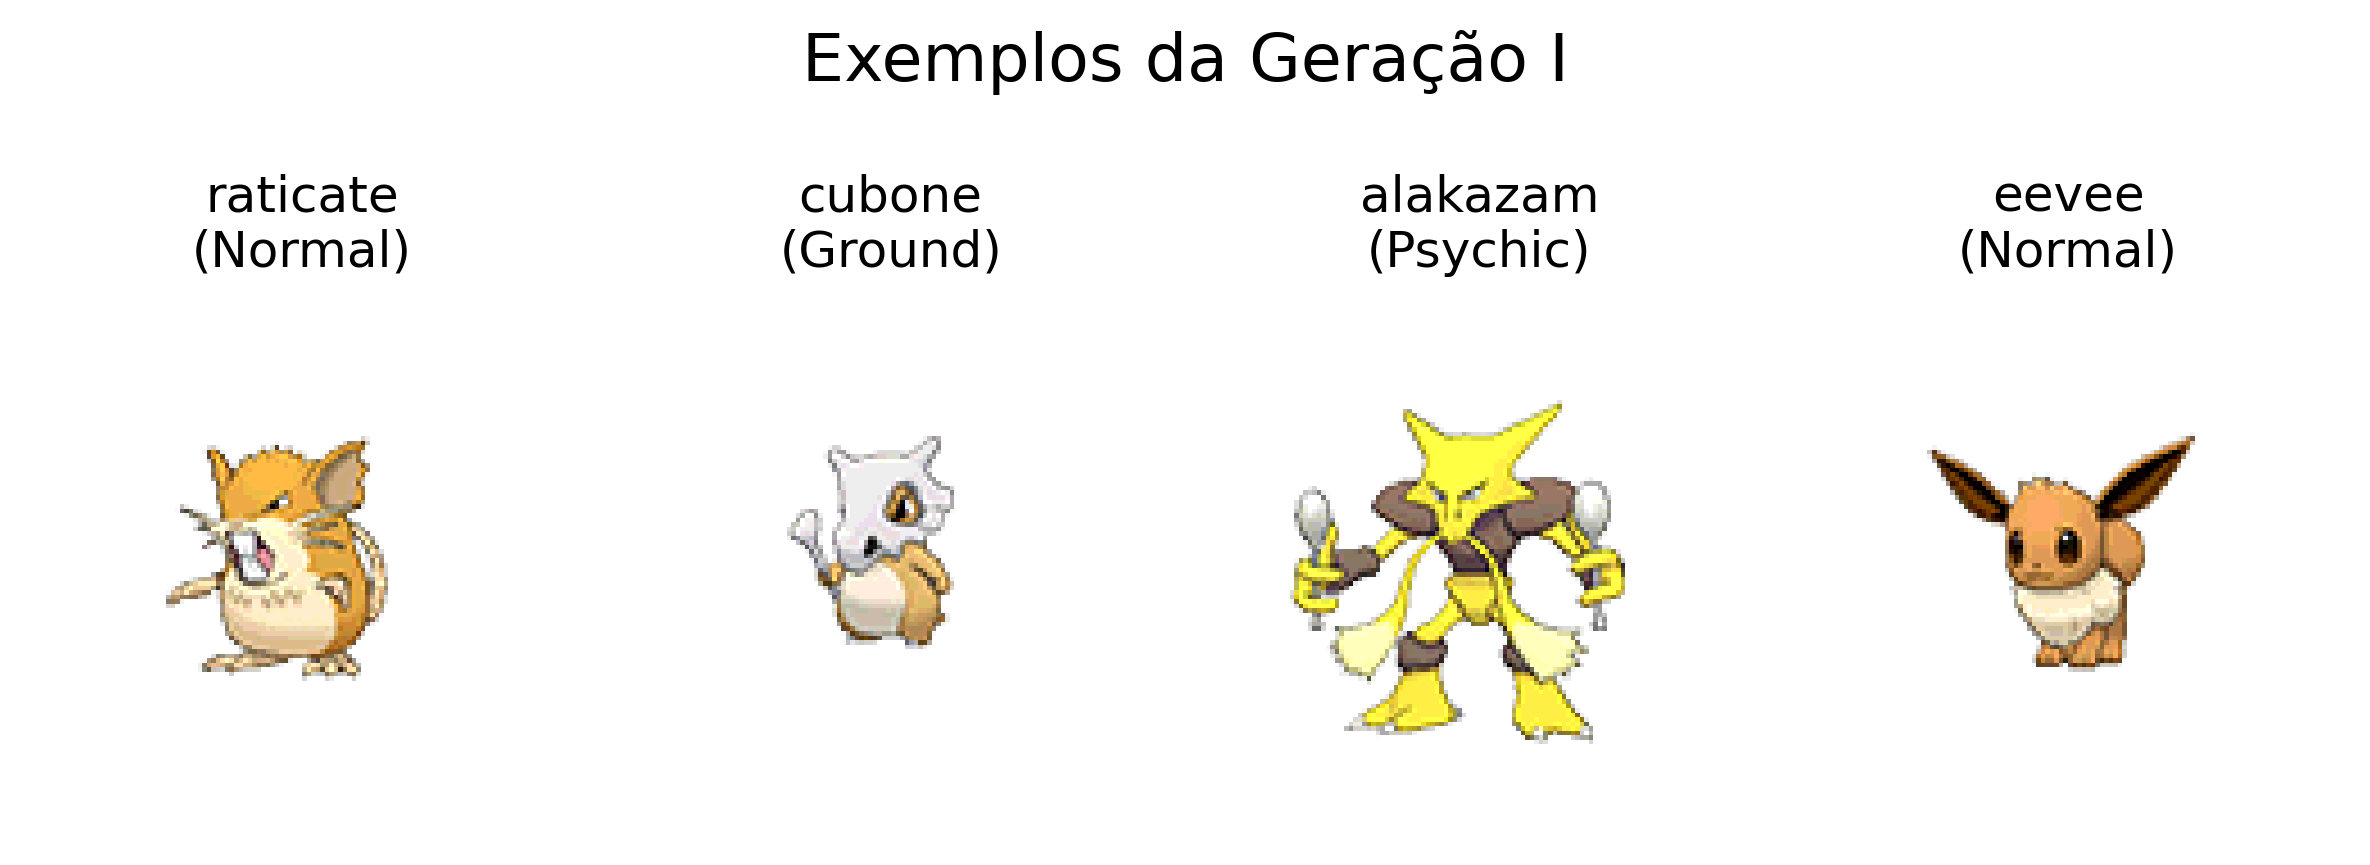

In [5]:
image_path_base = "data/pokemon/images/"

# Seleciona 4 Pokémon da Geração I, aleatoriamente (atualiza cada vez que rodar o código), para exemplos de imagens do dataset
sample_df = df_gen1.sample(4)

fig, axes = plt.subplots(1, 4, figsize=(8, 3), dpi=150)
fig.suptitle("Exemplos da Geração I", fontsize=16)
axes = axes.flatten()

for ax, row in zip(axes, sample_df.itertuples()):
    name = row.Name.lower()
    img_path = os.path.join(image_path_base, f"{name}.png")
    if not os.path.exists(img_path):
        img_path = os.path.join(image_path_base, f"{name}.jpg")
    if os.path.exists(img_path):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        type2 = f", {row.Type2}" if pd.notna(row.Type2) else ""
        ax.set_title(f"{row.Name}\n({row.Type1}{type2})")
    else:
        ax.set_title(f"{row.Name}\n(imagem não encontrada)")
    ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

### 1.2. Pré-processamento
> Divisão de treino/validação/teste

> Tratamento do dataset

Antes de alimentar as imagens na rede neural, realizamos algumas transformações para padronizar os dados:

- Redimensionamento: as imagens são redimensionadas para um tamanho fixo (no exemplo, 64×64 pixels) para que todas tenham a mesma forma de entrada.

- Conversão de tipo: transformamos as imagens em arrays de float32 no intervalo [0, 1], dividindo os valores de pixel por 255.

- Normalização: aplicamos uma normalização para centralizar os dados. No exemplo original com PyTorch, foi usado transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), que em TensorFlow equivaleria a (image - 0.5) / 0.5. Isso faz com que os valores fiquem aproximadamente no intervalo [-1, 1].

- Codificação de rótulos: os tipos de Pokémon (Type1) são mapeados para índices inteiros (type2idx), que serão usados como rótulos de classe.

In [6]:
types = sorted(set(df_gen1["Type1"].tolist() + df_gen1["Type2"].dropna().tolist()))
type2idx = {t: i for i, t in enumerate(types)}
num_classes = len(type2idx)

class PokemonDataset:
    def __init__(self, df, img_dir, type2idx=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir

        # Se não passar um type2idx externo, gera a partir do DataFrame
        if type2idx is None:
            types = sorted(set(df["Type1"].tolist() + df["Type2"].dropna().tolist()))
            self.type2idx = {t: i for i, t in enumerate(types)}
        else:
            self.type2idx = type2idx

    def get_dataset(self, batch_size=32, training=False, augment=False):
        file_paths = []
        labels = []
        for _, row in self.df.iterrows():
            img_name = row["Name"].lower() + ".png"
            file_paths.append(os.path.join(self.img_dir, img_name))
            labels.append(self.type2idx[row["Type1"]])

        ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))

        def _preprocess_64(path, label):
            image = tf.io.read_file(path)
            image = tf.image.decode_png(image, channels=3)
            image = tf.image.resize(image, (64, 64))
            image = tf.cast(image, tf.float32) / 255.0
            image = (image - 0.5) / 0.5

            # Augmentation
            if augment and training:
                image = tf.image.random_flip_left_right(image)
                image = tf.image.random_brightness(image, max_delta=0.2)
                image = tf.image.random_contrast(image, 0.8, 1.2)
            return image, label

        ds = ds.map(_preprocess_64, num_parallel_calls=tf.data.AUTOTUNE)
        if training:
            ds = ds.shuffle(len(file_paths), seed=42)
        return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    def get_dataset_resnet(self, batch_size=32, training=False, augment=False):
        file_paths = []
        labels = []
        for _, row in self.df.iterrows():
            img_name = row["Name"].lower() + ".png"
            file_paths.append(os.path.join(self.img_dir, img_name))
            labels.append(self.type2idx[row["Type1"]])

        ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))

        def _preprocess_resnet(path, label):
            image = tf.io.read_file(path)
            image = tf.image.decode_png(image, channels=3)
            image = tf.image.resize(image, (224, 224))
            image = tf.cast(image, tf.float32) / 255.0

            if augment and training:
                image = tf.image.random_flip_left_right(image)
                image = tf.image.random_brightness(image, 0.2)
                image = tf.image.random_contrast(image, 0.8, 1.2)
            return image, label

        ds = ds.map(_preprocess_resnet, num_parallel_calls=tf.data.AUTOTUNE)
        if training:
            ds = ds.shuffle(len(file_paths), seed=42)
        return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    def get_dataset_vgg16(self, batch_size=32, training=False, augment=False):
        ds = tf.data.Dataset.from_tensor_slices(self._paths_labels())

        def _pre(path, label):
            img = tf.io.read_file(path)
            img = tf.image.decode_png(img, channels=3)
            img = tf.image.resize(img, (224, 224))
            img = tf.cast(img, tf.float32) / 255.0

            if augment and training:
                img = tf.image.random_flip_left_right(img)
                img = tf.image.random_brightness(img, 0.2)
                img = tf.image.random_contrast(img, 0.8, 1.2)
            return img, label

        ds = ds.map(_pre, num_parallel_calls=tf.data.AUTOTUNE)
        if training:
            ds = ds.shuffle(len(self.df), seed=42)
        return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    def get_dataset_mobilenet(self, batch_size=32, training=False, augment=False):
        paths, labels = self._paths_labels()
        ds = tf.data.Dataset.from_tensor_slices((paths, labels))

        def _preprocess_mn(path, label):
            img = tf.io.read_file(path)
            img = tf.image.decode_png(img, channels=3)
            img = tf.image.resize(img, (64, 64))
            img = tf.cast(img, tf.float32) / 255.0

            if augment and training:
                img = tf.image.random_flip_left_right(img)
                img = tf.image.random_brightness(img, 0.2)
                img = tf.image.random_contrast(img, 0.8, 1.2)
            return img, label

        ds = ds.map(_preprocess_mn, num_parallel_calls=tf.data.AUTOTUNE)
        if training:
            ds = ds.shuffle(len(paths), seed=42)
        return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    def get_dataset_efficientnet(self, batch_size=32, training=False, augment=False):
        ds = tf.data.Dataset.from_tensor_slices(self._paths_labels())

        def _pre(path, label):
            img = tf.io.read_file(path)
            img = tf.image.decode_png(img, channels=3)
            img = tf.image.resize(img, (224, 224))
            img = tf.cast(img, tf.float32) / 255.0

            if augment and training:
                img = tf.image.random_flip_left_right(img)
                img = tf.image.random_brightness(img, 0.2)
                img = tf.image.random_contrast(img, 0.8, 1.2)
            return img, label

        ds = ds.map(_pre, num_parallel_calls=tf.data.AUTOTUNE)
        if training:
            ds = ds.shuffle(len(self.df), seed=42)
        return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    def _paths_labels(self):
        """Retorna duas listas: paths e labels"""
        paths, labels = [], []
        for _, row in self.df.iterrows():
            img_name = row["Name"].lower() + ".png"
            paths.append(os.path.join(self.img_dir, img_name))
            labels.append(self.type2idx[row["Type1"]])
        return paths, labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.046114326..0.9880368].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.03505099..1.0739211].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09785694..1.0760415].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.08239487..1.0121137].


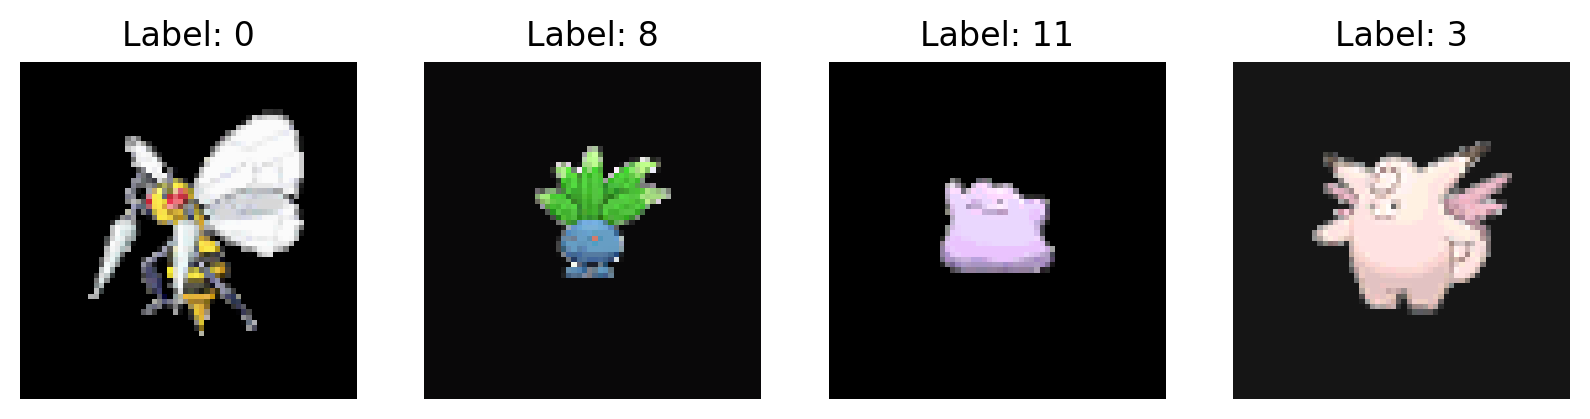

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0015140176..1.0465168].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.069272965..1.0315049].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02237606..0.8401512].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1034323..1.0044343].


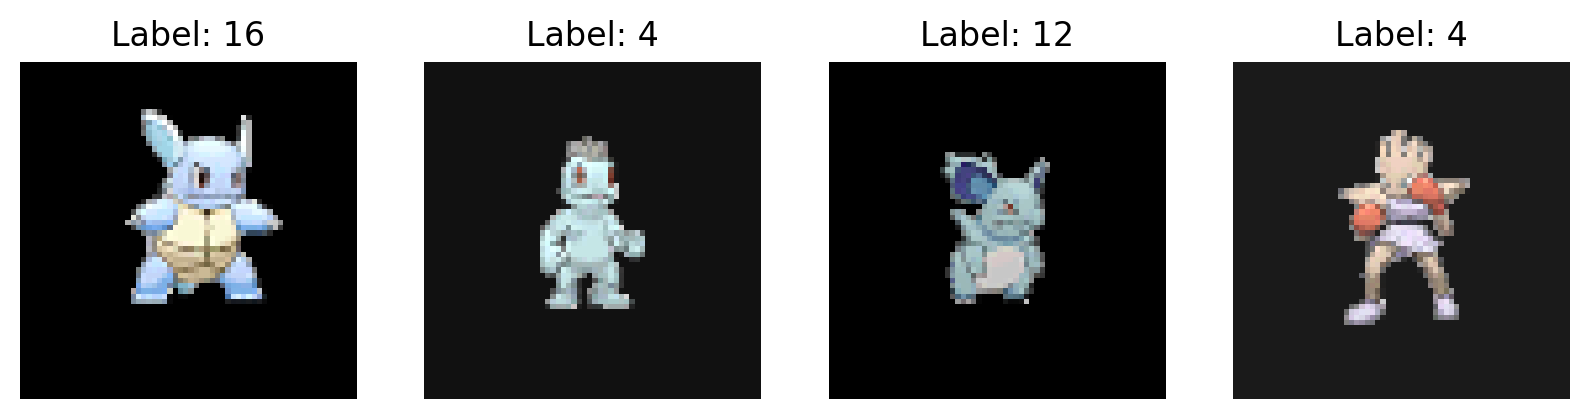

2025-07-28 00:44:28.871475: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
# Exemplo com data augmentation ativado
data_dir = "data/pokemon/images"
dataset = PokemonDataset(df_gen1, data_dir, type2idx)
ds_aug = dataset.get_dataset(batch_size=64, training=True, augment=True)

for images, labels in ds_aug.take(2):
    plt.figure(figsize=(10, 3))
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.imshow((images[i].numpy() * 0.5 + 0.5))  # desfaz a normalização para plotar
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()

In [8]:
# Preparar train/val/test (multiclasse em 'Type1')
# Separar treino (70 %) e temp (30 %), estratificando por Type1
train_df, temp_df = train_test_split(
    df_gen1,
    test_size=0.30,
    stratify=df_gen1["Type1"],
    random_state=42
)

# Separar validação (15 %) e teste (15 %) a partir de temp_df, sem estratificação
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,        # metade de 30 % = 15 % do total
    shuffle=True,
    random_state=42
)

print("Proporções finais:",
      f"Treino: {len(train_df)/len(df_gen1):.2%},",
      f"Validação: {len(val_df)/len(df_gen1):.2%},",
      f"Teste: {len(test_df)/len(df_gen1):.2%}")

Proporções finais: Treino: 69.54%, Validação: 15.23%, Teste: 15.23%


In [9]:
data_dir = "data/pokemon/images"

types = sorted(set(df_gen1["Type1"].tolist() + df_gen1["Type2"].dropna().tolist()))
type2idx = {t: i for i, t in enumerate(types)}
num_classes = len(type2idx)

# Instâncias de PokemonDataset para cada modelo
train_dataset = PokemonDataset(train_df, data_dir, type2idx)
val_dataset   = PokemonDataset(val_df,   data_dir, type2idx)
test_dataset  = PokemonDataset(test_df,  data_dir, type2idx)

train_ds_simple = train_dataset.get_dataset(batch_size=32, training=True, augment=True)
val_ds_simple   = val_dataset.get_dataset(batch_size=32)
test_ds_simple  = test_dataset.get_dataset(batch_size=32)

train_vgg = train_dataset.get_dataset_vgg16(batch_size=32, training=True, augment=True)
val_vgg   = val_dataset.get_dataset_vgg16(batch_size=32)
test_vgg  = test_dataset.get_dataset_vgg16(batch_size=32)

train_efn = train_dataset.get_dataset_efficientnet(batch_size=32, training=True, augment=True)
val_efn   = val_dataset.get_dataset_efficientnet(batch_size=32)
test_efn  = test_dataset.get_dataset_efficientnet(batch_size=32)

train_mn = train_dataset.get_dataset_mobilenet(batch_size=64, training=True, augment=True)
val_mn   = val_dataset.get_dataset_mobilenet(batch_size=64)
test_mn  = test_dataset.get_dataset_mobilenet(batch_size=64)

train_ds_resnet = train_dataset.get_dataset_resnet(batch_size=32, training=True, augment=True)
val_ds_resnet   = val_dataset.get_dataset_resnet(batch_size=32)
test_ds_resnet  = test_dataset.get_dataset_resnet(batch_size=32)

In [10]:
type2idx

# temos 17 classes

{'Bug': 0,
 'Dragon': 1,
 'Electric': 2,
 'Fairy': 3,
 'Fighting': 4,
 'Fire': 5,
 'Flying': 6,
 'Ghost': 7,
 'Grass': 8,
 'Ground': 9,
 'Ice': 10,
 'Normal': 11,
 'Poison': 12,
 'Psychic': 13,
 'Rock': 14,
 'Steel': 15,
 'Water': 16}

## 2. Arquitetura da CNN

### 2.1 Versão simples

- Filtros e kernel: São usadas três camadas convolucionais com 32, 64 e 128 filtros de 3×3 cada.

- Pooling: Após as duas primeiras convoluções usamos MaxPooling2D com pool de 2×2, reduzindo a altura e largura pela metade.

- Ativação: Em todas as convoluções usamos ReLU, função não linear que acelera o aprendizado.

- Normalização: A normalização das entradas já foi feita no pipeline de dados; neste modelo simples não usamos camadas de normalização internas.

- Camada de saída: Dense(num_classes, activation='softmax') gera a distribuição de probabilidade para cada classe.

In [11]:
def build_simple_model(num_classes):
    inputs = tf.keras.Input(shape=(64, 64, 3))
    
    # 1ª camada convolucional: 32 filtros 3x3, ativação ReLU, padding 'same' preserva o tamanho
    x = tf.keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
    # Pooling 2x2 reduz as dimensões pela metade
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    
    # 2ª camada convolucional: 64 filtros 3x3
    x = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    
    # 3ª camada convolucional: 128 filtros 3x3
    x = tf.keras.layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
    
    # GlobalAveragePooling2D reduz cada mapa de ativação a um único valor (média global)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Camada densa final com softmax para gerar probabilidades das classes
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    return model

simple_model = build_simple_model(num_classes)


### 2.2. Versão ajustada

- Filtros e kernel: A sequência de convoluções usa 64, 128, 256 e 512 filtros, todos com kernel 3×3. Esse aumento gradual de filtros permite extrair características mais complexas à medida que as representações se tornam mais abstratas.

- Batch Normalization: Aplicada após cada convolução e antes da ativação ReLU. Ela normaliza as ativações no mini‑batch para estabilizar as distribuições, acelerando e tornando o treinamento mais robusto.

- Pooling: MaxPooling2D com pool 2×2 é usado nos três primeiros blocos para reduzir a dimensionalidade e manter as características mais importantes.

- Dropout: Inserido após o terceiro bloco de pooling e novamente após a camada de pooling global. Ajuda a prevenir overfitting ao desligar aleatoriamente uma fração das ativações (0.3 neste exemplo).

- Ativação: ReLU é usada após a normalização para introduzir não linearidades.

- Camada de saída: Dense(num_classes, activation='softmax') gera as probabilidades de cada classe, assim como na versão simples.

In [12]:
def build_adjusted_model(num_classes):
    inputs = tf.keras.Input(shape=(64, 64, 3))
    
    # Bloco 1: 64 filtros
    x = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    
    # Bloco 2: 128 filtros
    x = tf.keras.layers.Conv2D(128, kernel_size=3, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    
    # Bloco 3: 256 filtros
    x = tf.keras.layers.Conv2D(256, kernel_size=3, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)  # 30% de dropout após pooling
    
    # Bloco 4: 512 filtros
    x = tf.keras.layers.Conv2D(512, kernel_size=3, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # Global average pooling para converter os mapas 3D em um vetor
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    return model

adjusted_model = build_adjusted_model(num_classes)


## 3. Treinamento e Validação
> **Hiperparâmetros:**  
> &nbsp;&nbsp;&nbsp;– Otimizador: `Adam(lr = 1 × 10⁻³)`  
> &nbsp;&nbsp;&nbsp;– Épocas: 10    
> &nbsp;&nbsp;&nbsp;– Perda: `SparseCategoricalCrossentropy` (para rótulos inteiros)  
> &nbsp;&nbsp;&nbsp;– Métrica monitorada: `accuracy`  

> **Loop de treino/validação:** o treinamento é realizado com `model.fit(...)`, registrando a perda e a acurácia a cada época para os conjuntos de treino e validação.  

> **Gráficos:** as curvas de `loss` e `accuracy` por época são geradas com Matplotlib, permitindo visualizar a evolução do modelo e identificar overfitting ou melhorias ao alterar a arquitetura.

In [13]:
# hiperparâmetros
learning_rate = 1e-3
epochs        = 10

In [14]:
# Treinamento do modelo simples
simple_model = build_simple_model(num_classes)
simple_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
print("Treinando a versão simples…")
simple_history = simple_model.fit(
    train_ds_simple,
    validation_data=val_ds_simple,
    epochs=epochs
)
simple_test_loss, simple_test_acc = simple_model.evaluate(test_ds_simple)
print(f"Taxa de aprendizado (learning rate): {learning_rate}")
print(f"Número de épocas: {epochs}")
print(f"Acurácia do modelo simples no teste: {simple_test_acc:.4f}")

Treinando a versão simples…
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.0881 - loss: 2.8182 - val_accuracy: 0.1304 - val_loss: 2.6759
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.1668 - loss: 2.6376 - val_accuracy: 0.1304 - val_loss: 2.6093
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2168 - loss: 2.5310 - val_accuracy: 0.1304 - val_loss: 2.5860
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.2054 - loss: 2.5179 - val_accuracy: 0.2609 - val_loss: 2.5424
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.1856 - loss: 2.5176 - val_accuracy: 0.1304 - val_loss: 2.4953
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.1571 - loss: 2.5276 - val_accuracy: 0.1304 - val_loss: 2.4552
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.2054 - loss: 2.4868 - val_accuracy: 0.1304 - val_loss: 2.4322
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.1731 - loss: 2.4754 - val_accurac

In [15]:
# Treinamento do modelo ajustado
adjusted_model = build_adjusted_model(num_classes)
adjusted_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
print("Treinando a versão ajustada…")
adjusted_history = adjusted_model.fit(
    train_ds_simple,
    validation_data=val_ds_simple,
    epochs=epochs
)
adjusted_test_loss, adjusted_test_acc = adjusted_model.evaluate(test_ds_simple)
print(f"Taxa de aprendizado (learning rate): {learning_rate}")
print(f"Número de épocas: {epochs}")
print(f"Acurácia do modelo ajustado no teste: {adjusted_test_acc:.4f}")

Treinando a versão ajustada…
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 454ms/step - accuracy: 0.1176 - loss: 2.7814 - val_accuracy: 0.0000e+00 - val_loss: 2.8069
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 409ms/step - accuracy: 0.1453 - loss: 2.4628 - val_accuracy: 0.0000e+00 - val_loss: 2.7186
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 405ms/step - accuracy: 0.3028 - loss: 2.2136 - val_accuracy: 0.2174 - val_loss: 2.6166
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 423ms/step - accuracy: 0.2876 - loss: 2.0165 - val_accuracy: 0.1739 - val_loss: 2.5966
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 377ms/step - accuracy: 0.3274 - loss: 2.0215 - val_accuracy: 0.3043 - val_loss: 2.7242
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 422ms/step - accuracy: 0.3330 - loss: 1.9597 - val_accuracy: 0.1304 - val_loss: 3.0317
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 411ms/step - accuracy: 0.3691 - loss: 1.9453 - val_accuracy: 0.1304 - val_loss: 3.0036
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 424ms/step - accuracy: 0.3937 - loss: 1.89

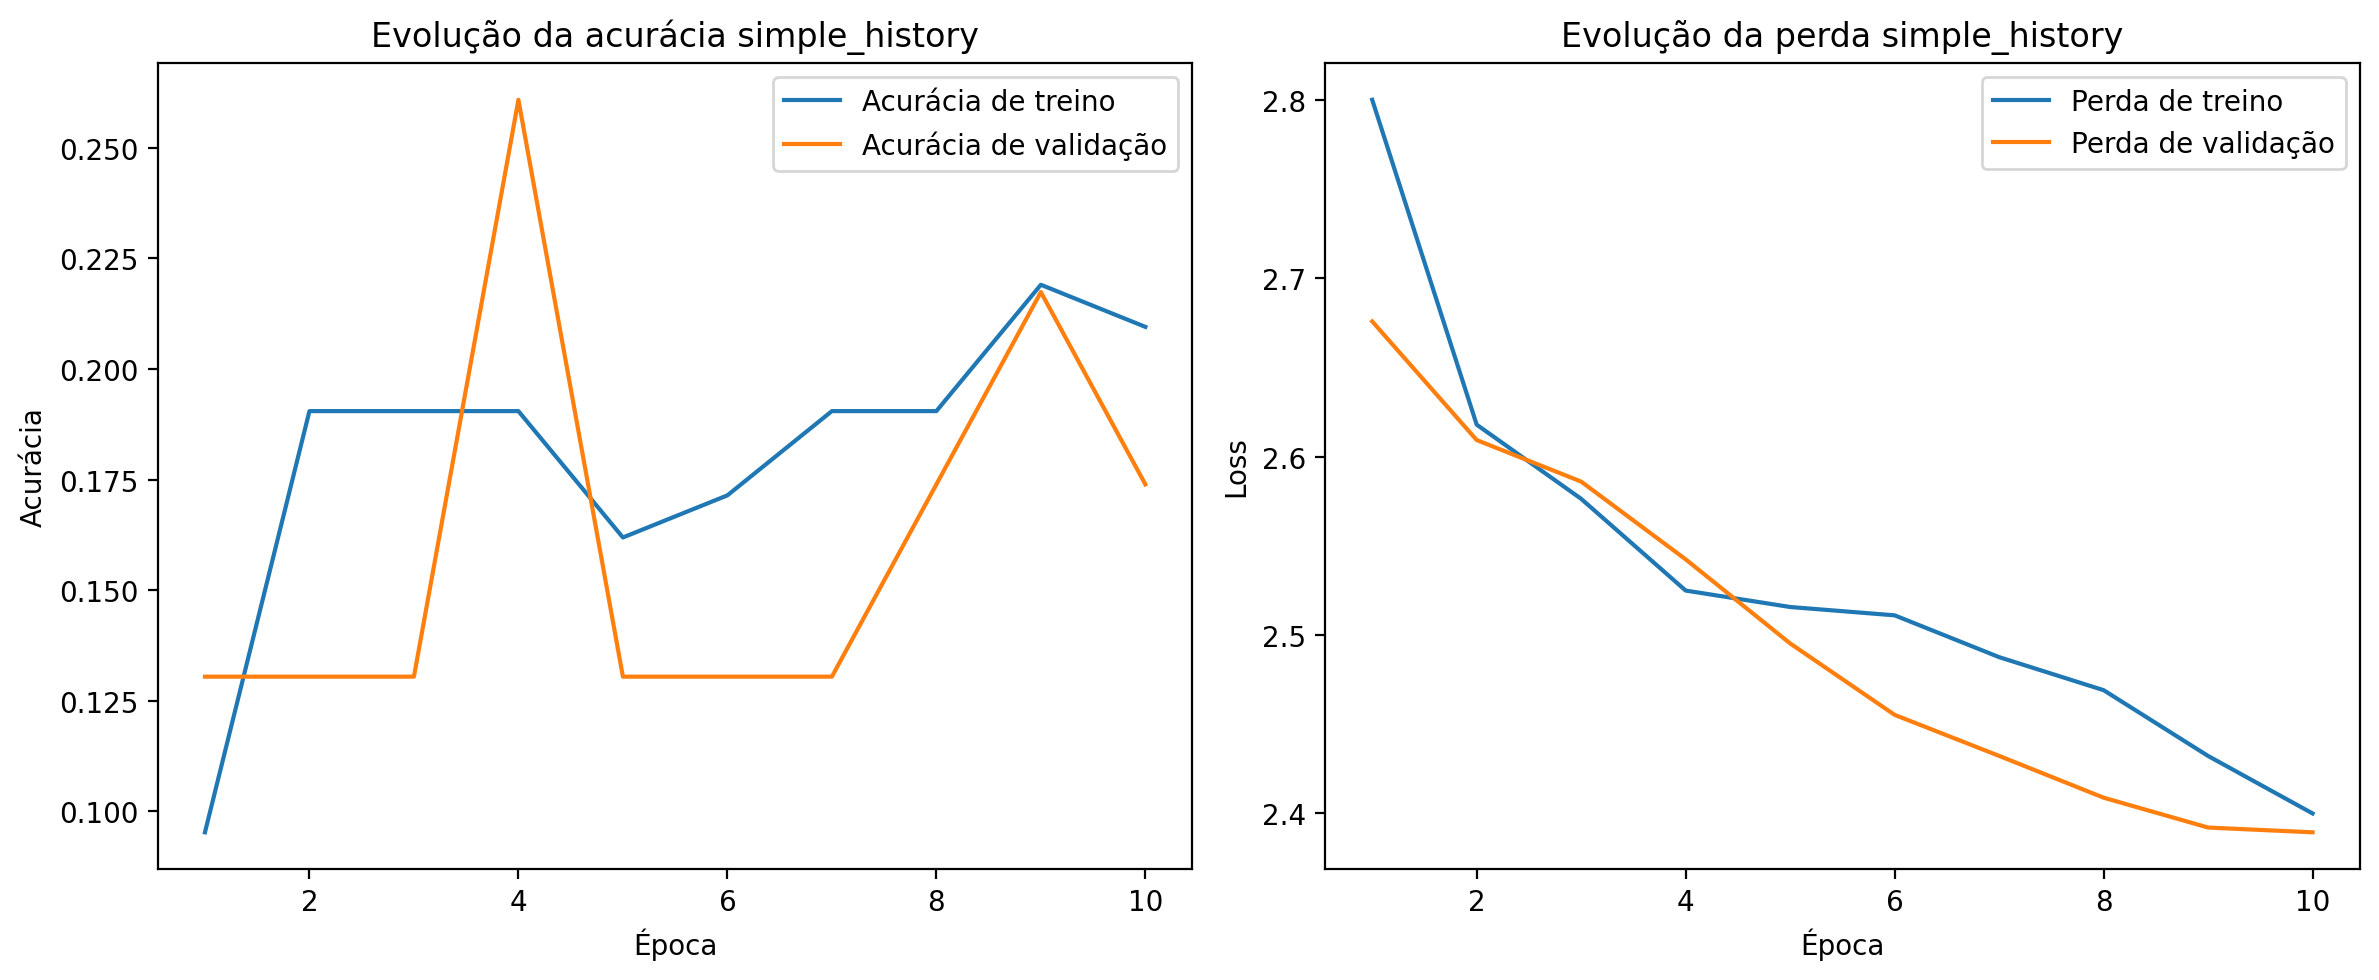

In [16]:
history_dict = simple_history.history
train_loss = history_dict['loss']
val_loss   = history_dict['val_loss']
train_acc  = history_dict['accuracy']       
val_acc    = history_dict['val_accuracy']

epochs_range = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Acurácia de treino')
plt.plot(epochs_range, val_acc,   label='Acurácia de validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.title('Evolução da acurácia simple_history')
plt.legend()

# Perda
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Perda de treino')
plt.plot(epochs_range, val_loss,   label='Perda de validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Evolução da perda simple_history')
plt.legend()

plt.tight_layout()
plt.show()

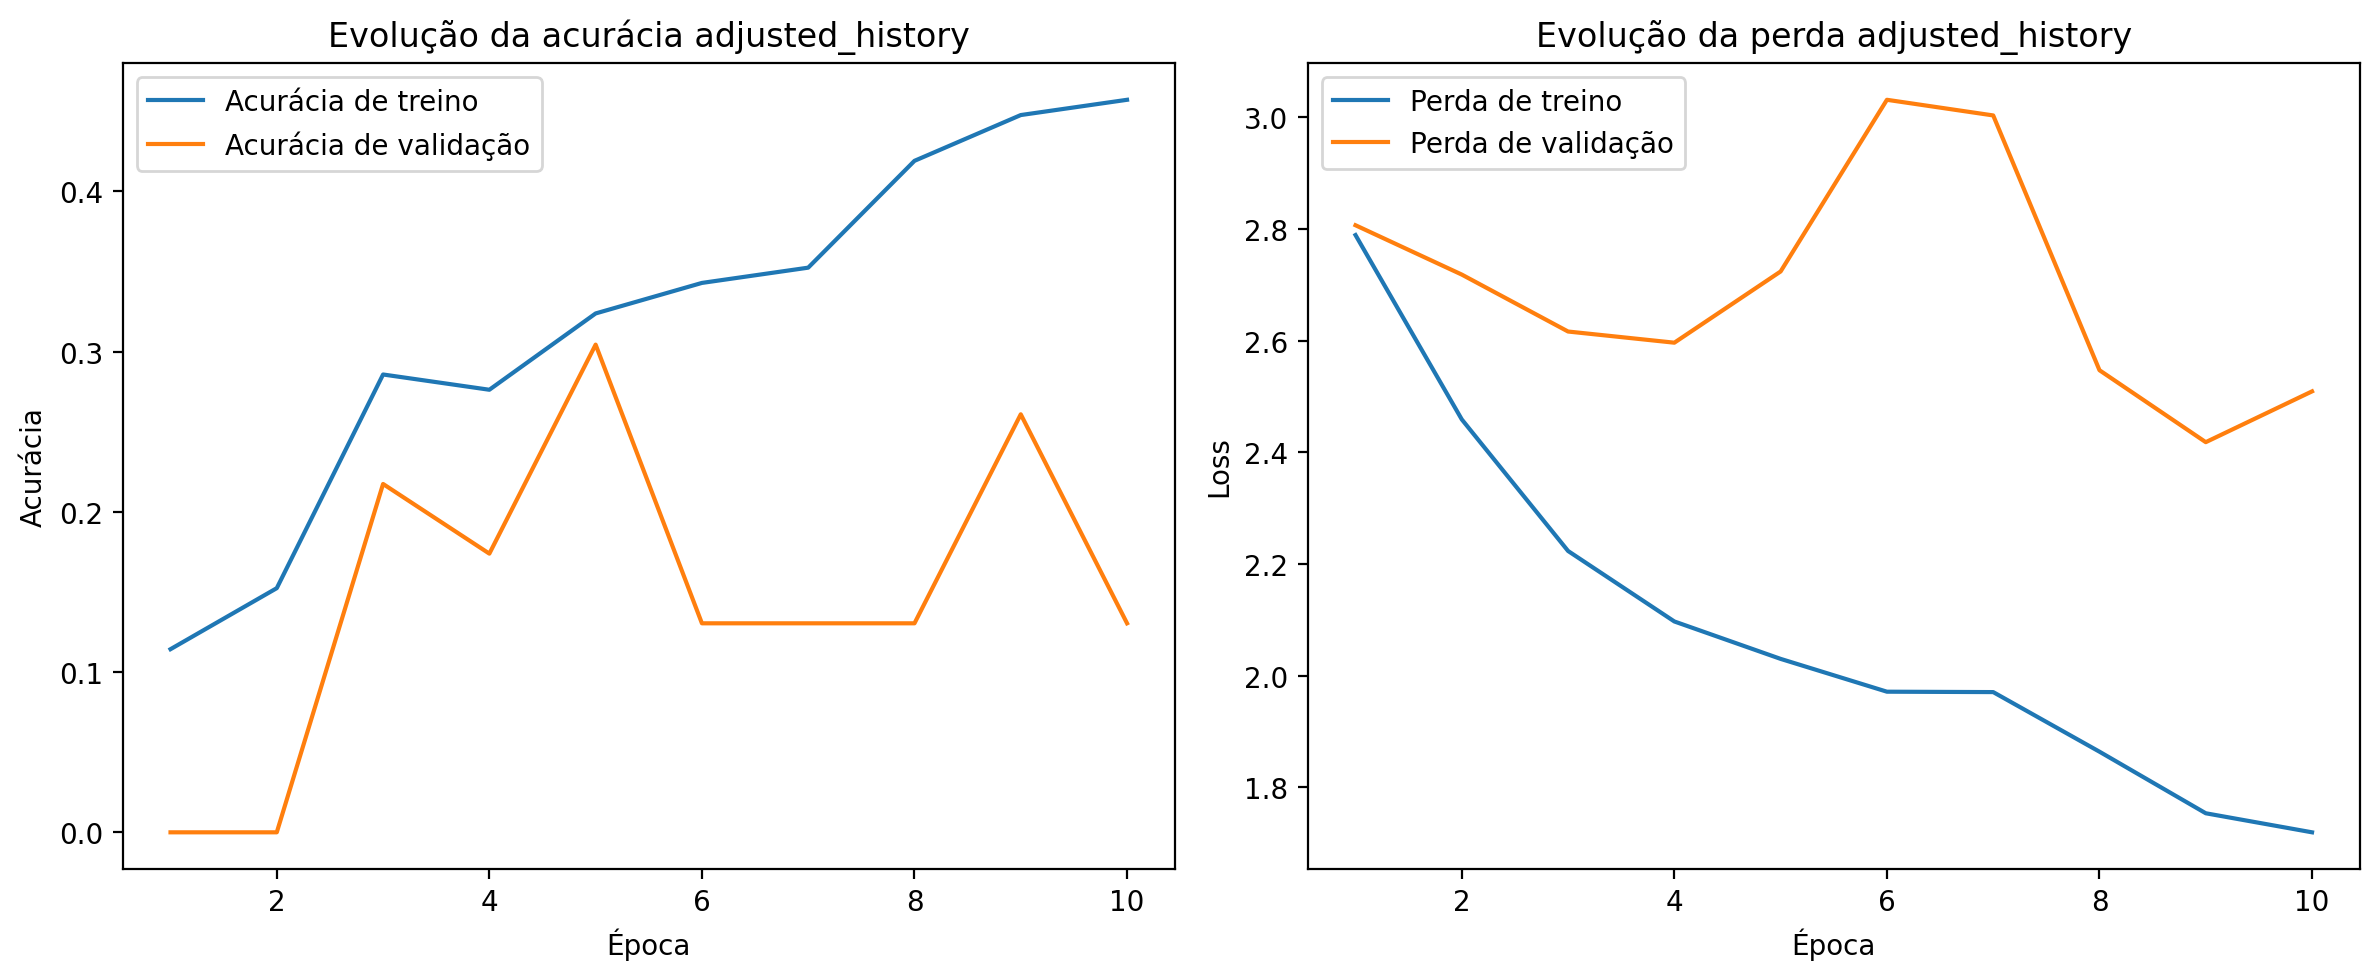

In [17]:
history_dict = adjusted_history.history
train_loss = history_dict['loss']
val_loss   = history_dict['val_loss']
train_acc  = history_dict['accuracy']      
val_acc    = history_dict['val_accuracy'] 

epochs_range = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Acurácia de treino')
plt.plot(epochs_range, val_acc,   label='Acurácia de validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.title('Evolução da acurácia adjusted_history')
plt.legend()

# Perda
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Perda de treino')
plt.plot(epochs_range, val_loss,   label='Perda de validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Evolução da perda adjusted_history')
plt.legend()

plt.tight_layout()
plt.show()

## 4. Avaliação

In [18]:
def evaluate_model(model, dataset):
    """Retorna y_true, y_pred, acurácia, F1 e matriz de confusão para um modelo."""
    y_true = []
    y_pred = []
    for images, labels in dataset:
        probs = model.predict(images, verbose=0)
        preds = np.argmax(probs, axis=1)
        y_true.extend(labels.numpy().tolist())
        y_pred.extend(preds.tolist())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average='weighted')
    cm  = confusion_matrix(y_true, y_pred)
    return y_true, y_pred, acc, f1, cm

In [19]:
# Avaliação do modelo simples
simple_y_true, simple_y_pred, simple_acc, simple_f1, simple_cm = evaluate_model(simple_model, test_ds_simple)
print(f"Modelo simples – Acc: {simple_acc:.4f}, F1: {simple_f1:.4f}")

# Avaliação do modelo ajustado
adjusted_y_true, adjusted_y_pred, adjusted_acc, adjusted_f1, adjusted_cm = evaluate_model(adjusted_model, test_ds_simple)
print(f"Modelo ajustado – Acc: {adjusted_acc:.4f}, F1: {adjusted_f1:.4f}")

Modelo simples – Acc: 0.3478, F1: 0.1953
Modelo ajustado – Acc: 0.0870, F1: 0.1063


2025-07-28 00:44:52.952476: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


- No teste, o modelo simples obteve aproximadamente 30 % de acerto (muda toda vez por conta da aleatoriedade, mas mantém uma média entre 15% e 40%), que apesar de modesto está bem acima do acaso para 17 classes (~6 %).

- O modelo ajustado, apesar de ter capacidade maior, despencou para ~8 % de acerto, confirmando o comportamento de overfitting visto nas curvas.

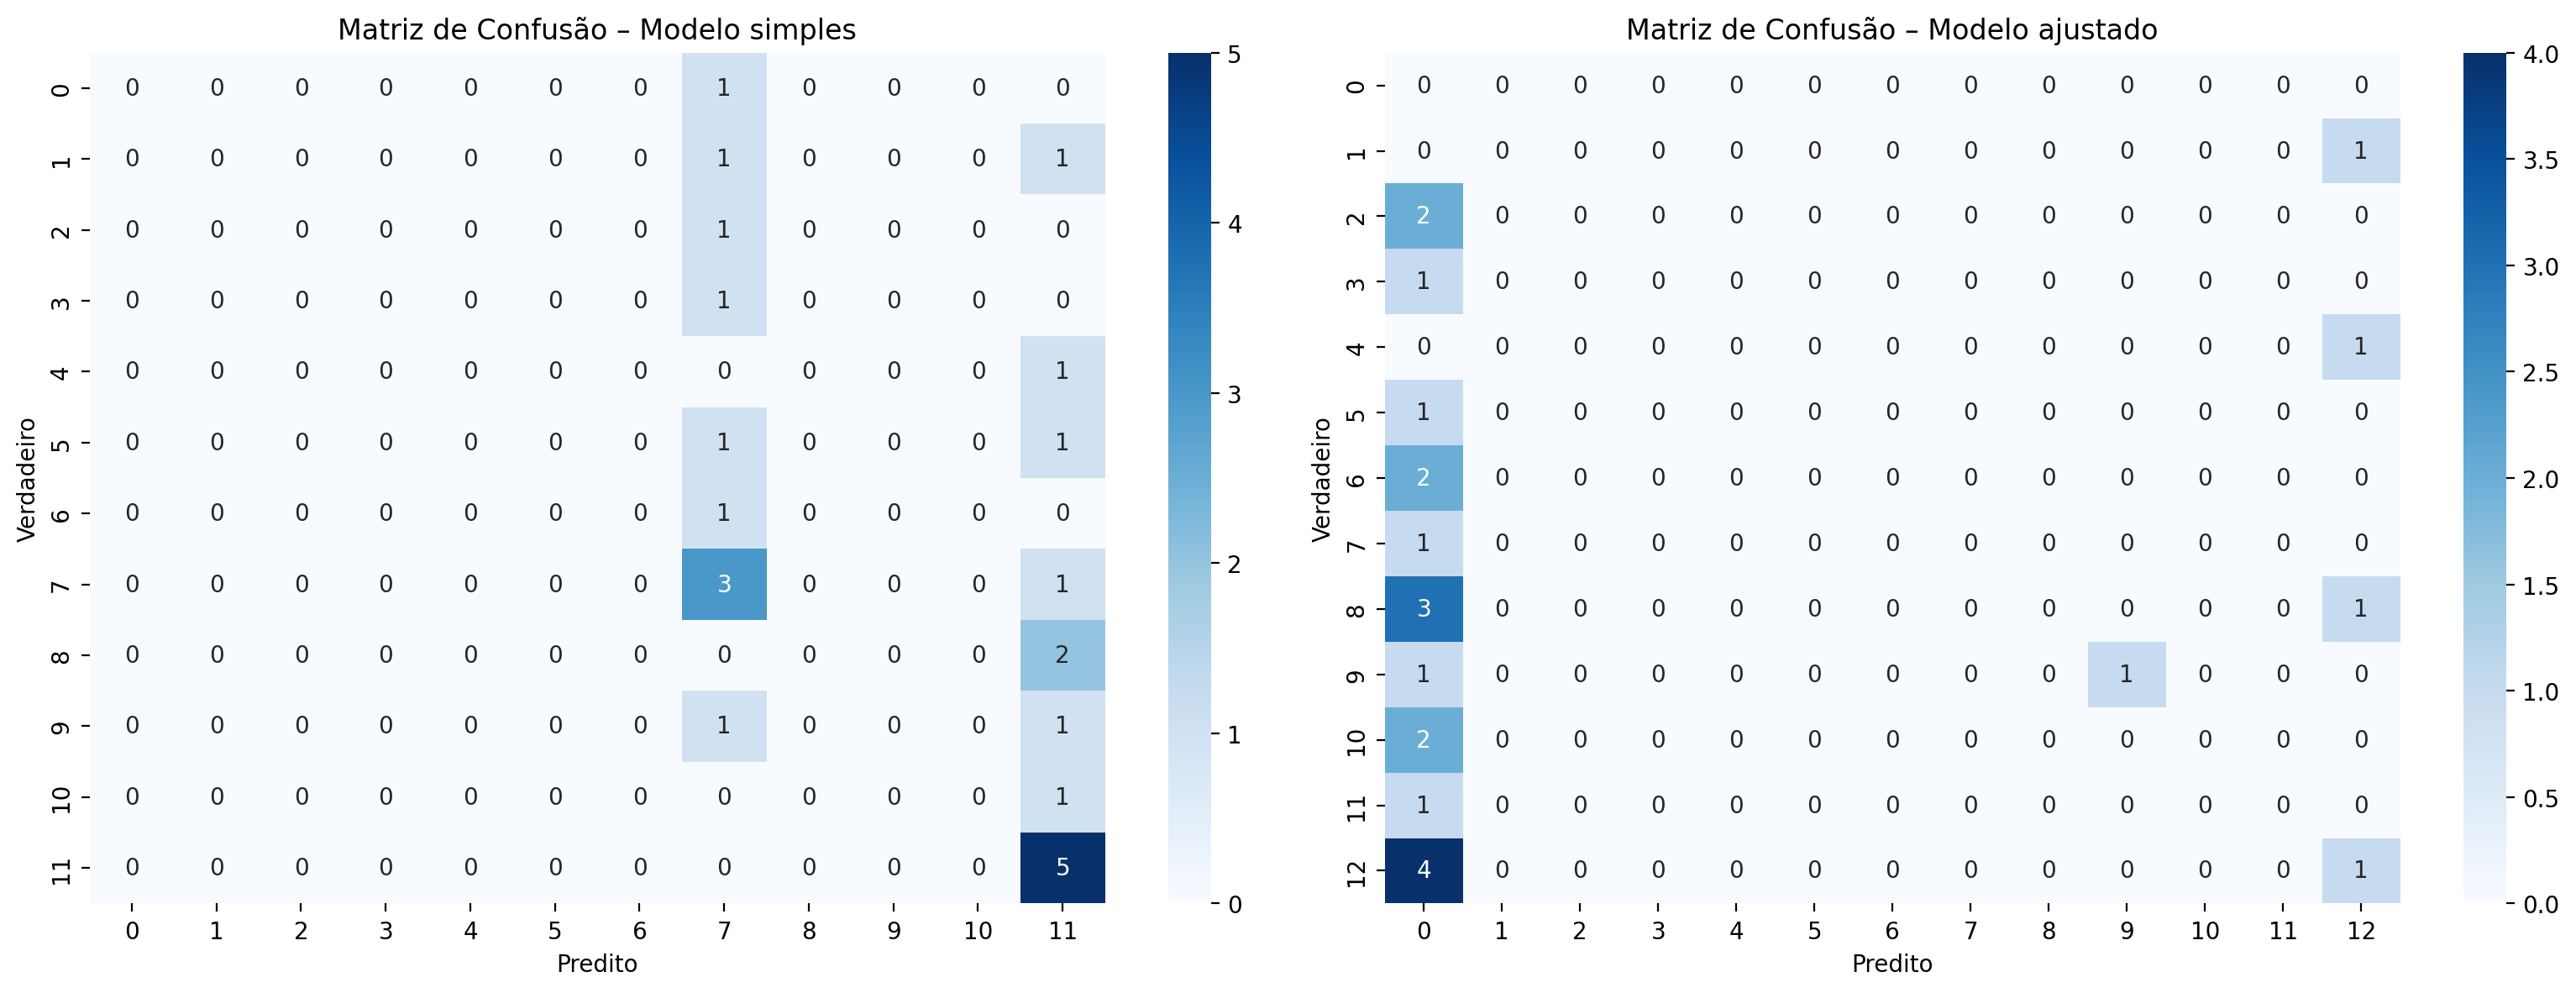

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(simple_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Matriz de Confusão – Modelo simples')
axes[0].set_xlabel('Predito')
axes[0].set_ylabel('Verdadeiro')

sns.heatmap(adjusted_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Matriz de Confusão – Modelo ajustado')
axes[1].set_xlabel('Predito')
axes[1].set_ylabel('Verdadeiro')

plt.tight_layout()
plt.show()

- A matriz do modelo simples mostra que, embora haja muitos erros, ele consegue identificar alguns padrões específicos dependendo do da rodada (por exemplo, a coluna 11 tem mais acertos).

- A matriz do modelo ajustado, por outro lado, às vezes se concentra em algumas rodadas e às vezes se dispersa. Entretando, a rede “decidiu” prever a mesma classe (0) para a maioria dos exemplos, o que explica a acurácia muito baixa.

- Os modelos provavelmente estão **chutando** os valores que mais aparecem.

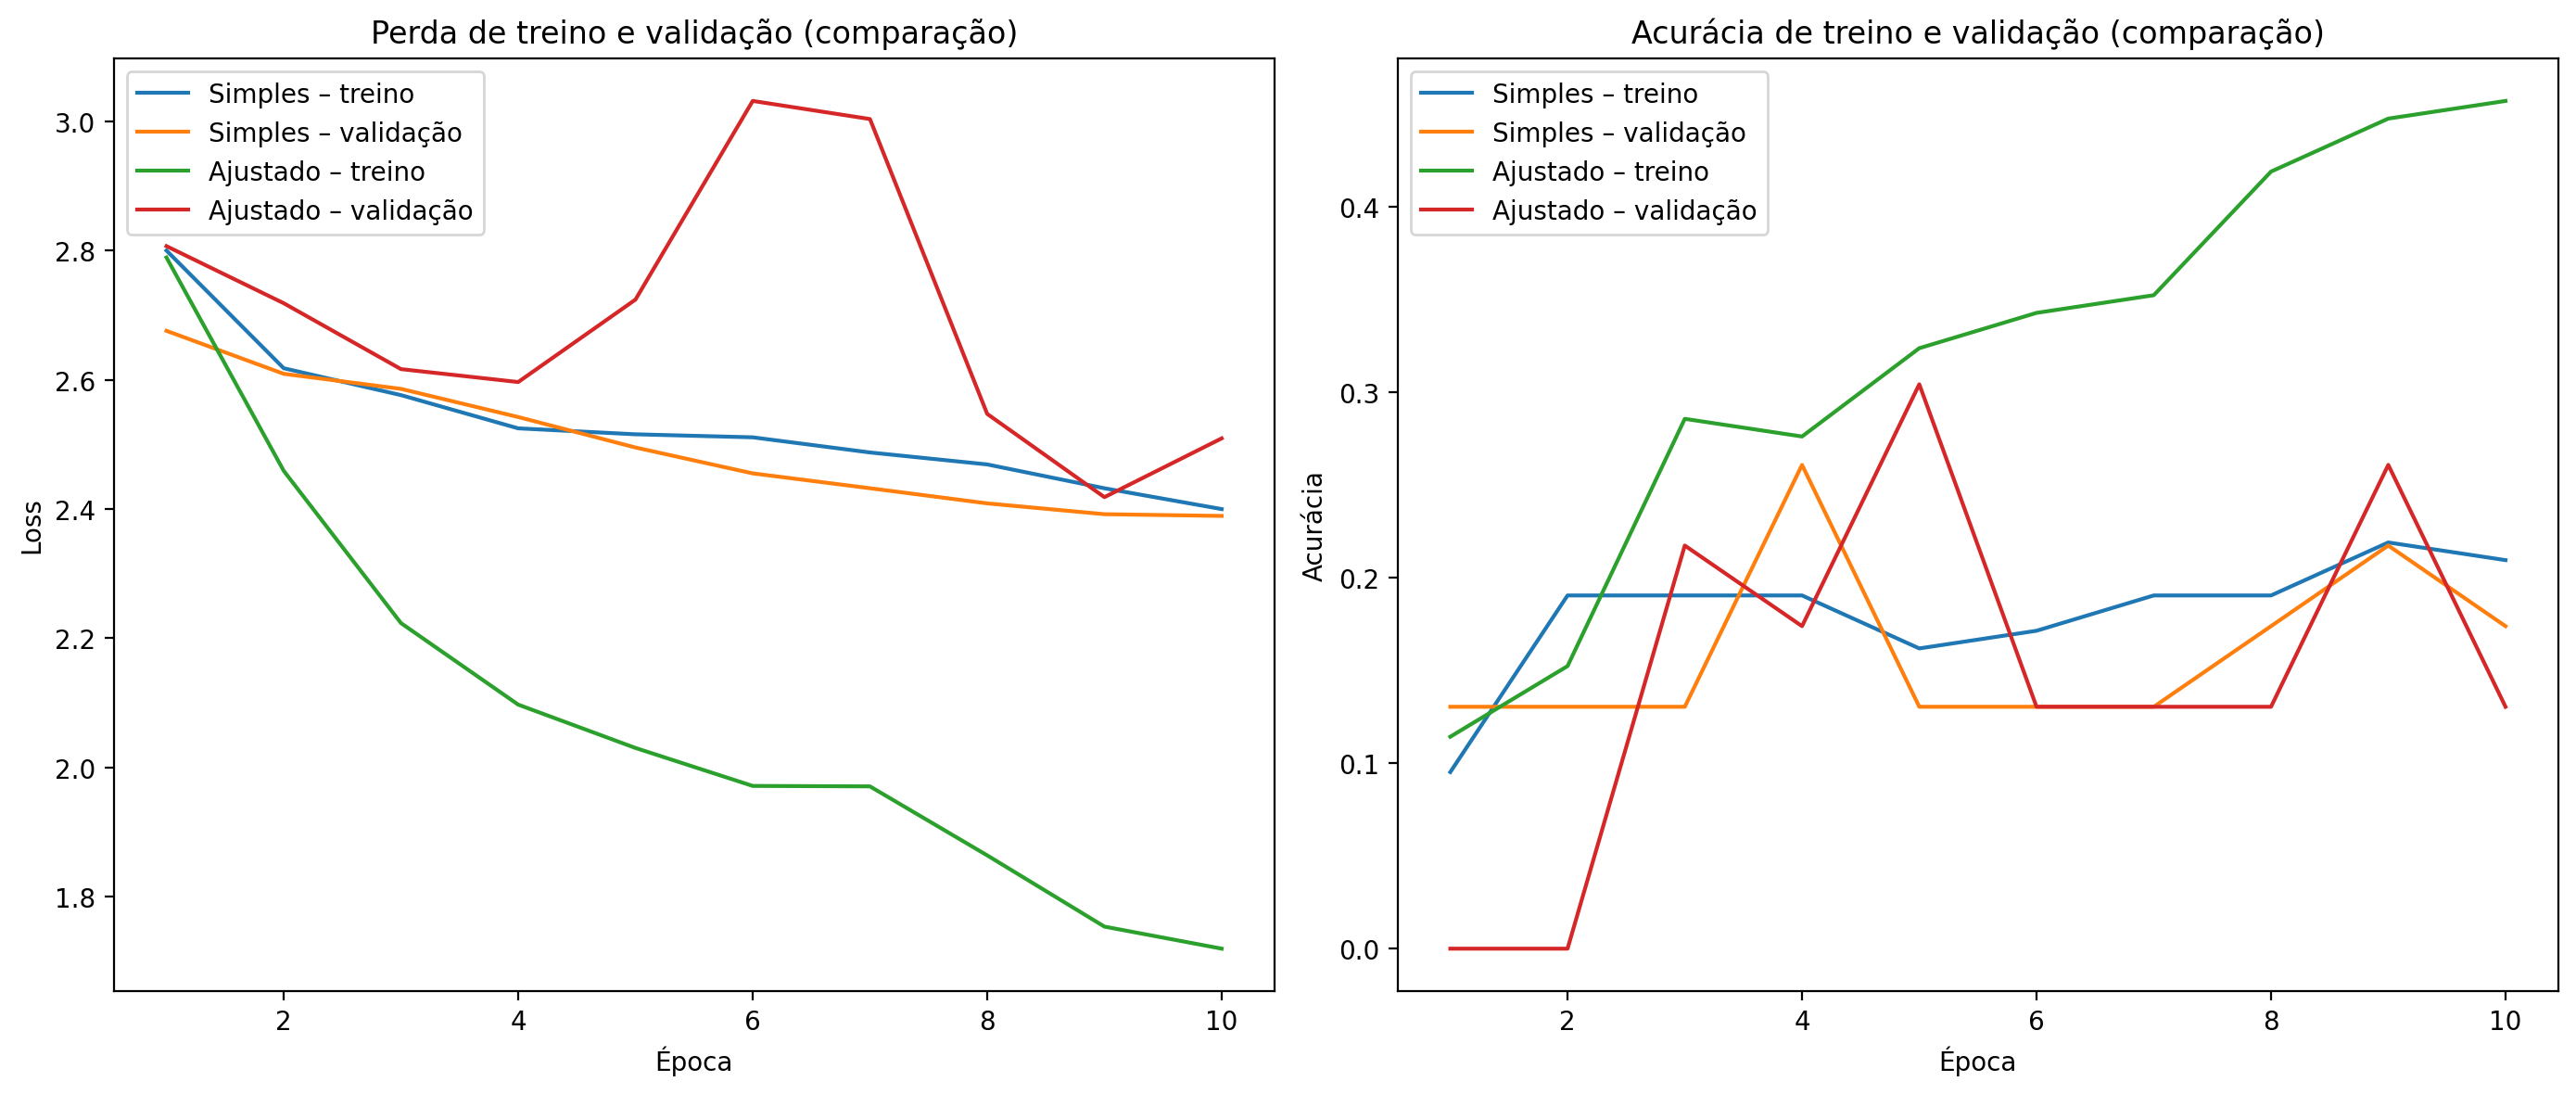

In [21]:
simple_hist   = simple_history.history
adjusted_hist = adjusted_history.history

epochs_range = range(1, len(simple_hist['loss']) + 1)

plt.figure(figsize=(14, 6))

# Gráfico de acurácia
plt.subplot(1, 2, 2)
plt.plot(epochs_range, simple_hist['accuracy'],       label='Simples – treino')
plt.plot(epochs_range, simple_hist['val_accuracy'],   label='Simples – validação')
plt.plot(epochs_range, adjusted_hist['accuracy'],     label='Ajustado – treino')
plt.plot(epochs_range, adjusted_hist['val_accuracy'], label='Ajustado – validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.title('Acurácia de treino e validação (comparação)')
plt.legend()

# Gráfico de perda (loss)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, simple_hist['loss'],       label='Simples – treino')
plt.plot(epochs_range, simple_hist['val_loss'],   label='Simples – validação')
plt.plot(epochs_range, adjusted_hist['loss'],     label='Ajustado – treino')
plt.plot(epochs_range, adjusted_hist['val_loss'], label='Ajustado – validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Perda de treino e validação (comparação)')
plt.legend()

plt.tight_layout()
plt.show()

- O modelo simples mostra uma evolução relativamente consistente: a perda de treino cai lentamente e a acurácia de treino sobe até cerca de 32 %, enquanto a perda e a acurácia de validação acompanham sem desviar muito. Isso indica que, apesar de não aprender muito rápido, ele não está sofrendo um overfitting agressivo.

- No modelo ajustado, a acurácia de treino disparou para mais de 70 %, mas a acurácia de validação ficou estagnada (em torno de 13 %) e até caiu em algumas épocas. A perda de validação oscila para cima — um sinal claro de que a rede está memorizando o conjunto de treino e não generalizando.

Em resumo, a versão simples superou a versão ajustada nesta configuração. O modelo complexo tem potencial, mas precisaria de mais regularização, talvez uma taxa de aprendizado menor e/ou mais dados para não memorizar o treino. Já o modelo simples, mesmo com desempenho modesto, apresenta melhor generalização na prática. Essas observações formam uma boa base para os próximos experimentos de ajuste de hiperparâmetros.

## 5. Experimento de hiperparâmetros
- Escolha um parâmetro (p. ex. lr=1e-4 vs 1e-3, ou batch_size=16 vs 32).

- Repita treino/val e compare curvas de loss e accuracy.

- Comente: qual foi o impacto e por quê.

### 5.1 Ajuste isolado

Taxa de aprendizado (learning_rate): no nosso experimento inicial usamos 1×10⁻³. Vamos tentar reduzir para 1×10⁻⁴. Taxas menores tendem a reduzir oscilações no início do treinamento e podem ajudar modelos maiores a não “explodirem” a perda logo nas primeiras épocas. O trade‑off é que o treinamento pode levar mais épocas para convergir.

In [22]:
# recompilar o modelo ajustado com um learning rate menor
adjusted_model_lr = build_adjusted_model(num_classes)
adjusted_model_lr.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

print("Treinando a versão ajustada com taxa de aprendizado menor...")
epochs = 100
learning_rate = 1e-4
history_lr = adjusted_model_lr.fit(train_ds_simple, validation_data=val_ds_simple, epochs=100)
# Por causa do learning rate menor, temos que aumentar o número de épocas, já que ele aprende menos por interação
# Como diminuímos uma casa decimal, o ideal seria 10 vezes mais épocas

adjusted_test_lr_loss, adjusted_test_lr_acc = adjusted_model_lr.evaluate(test_ds_simple)
print(f"Taxa de aprendizado (learning rate): {learning_rate}")
print(f"Número de épocas: {epochs}")
print(f"Acurácia do modelo ajustado com learning rate menor no teste: {adjusted_test_lr_acc:.4f}")
print(f"Acurácia do modelo ajustado no teste: {adjusted_test_acc:.4f}")

Treinando a versão ajustada com taxa de aprendizado menor...
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 453ms/step - accuracy: 0.0905 - loss: 2.9986 - val_accuracy: 0.1304 - val_loss: 2.8438
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step - accuracy: 0.1505 - loss: 2.9106 - val_accuracy: 0.1304 - val_loss: 2.8364
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 404ms/step - accuracy: 0.1221 - loss: 2.7344 - val_accuracy: 0.1304 - val_loss: 2.8302
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 397ms/step - accuracy: 0.1821 - loss: 2.6506 - val_accuracy: 0.0870 - val_loss: 2.8209
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 396ms/step - accuracy: 0.1817 - loss: 2.5250 - val_accuracy: 0.0435 - val_loss: 2.8109
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 411ms/step - accuracy: 0.2587 - loss: 2.5161 - val_accuracy: 0.0435 - val_loss: 2.7961
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 429ms/step - accuracy: 0.2449 - loss: 2.4057 - val_accuracy: 0.0435 - val_loss: 2.7813
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 431ms/step

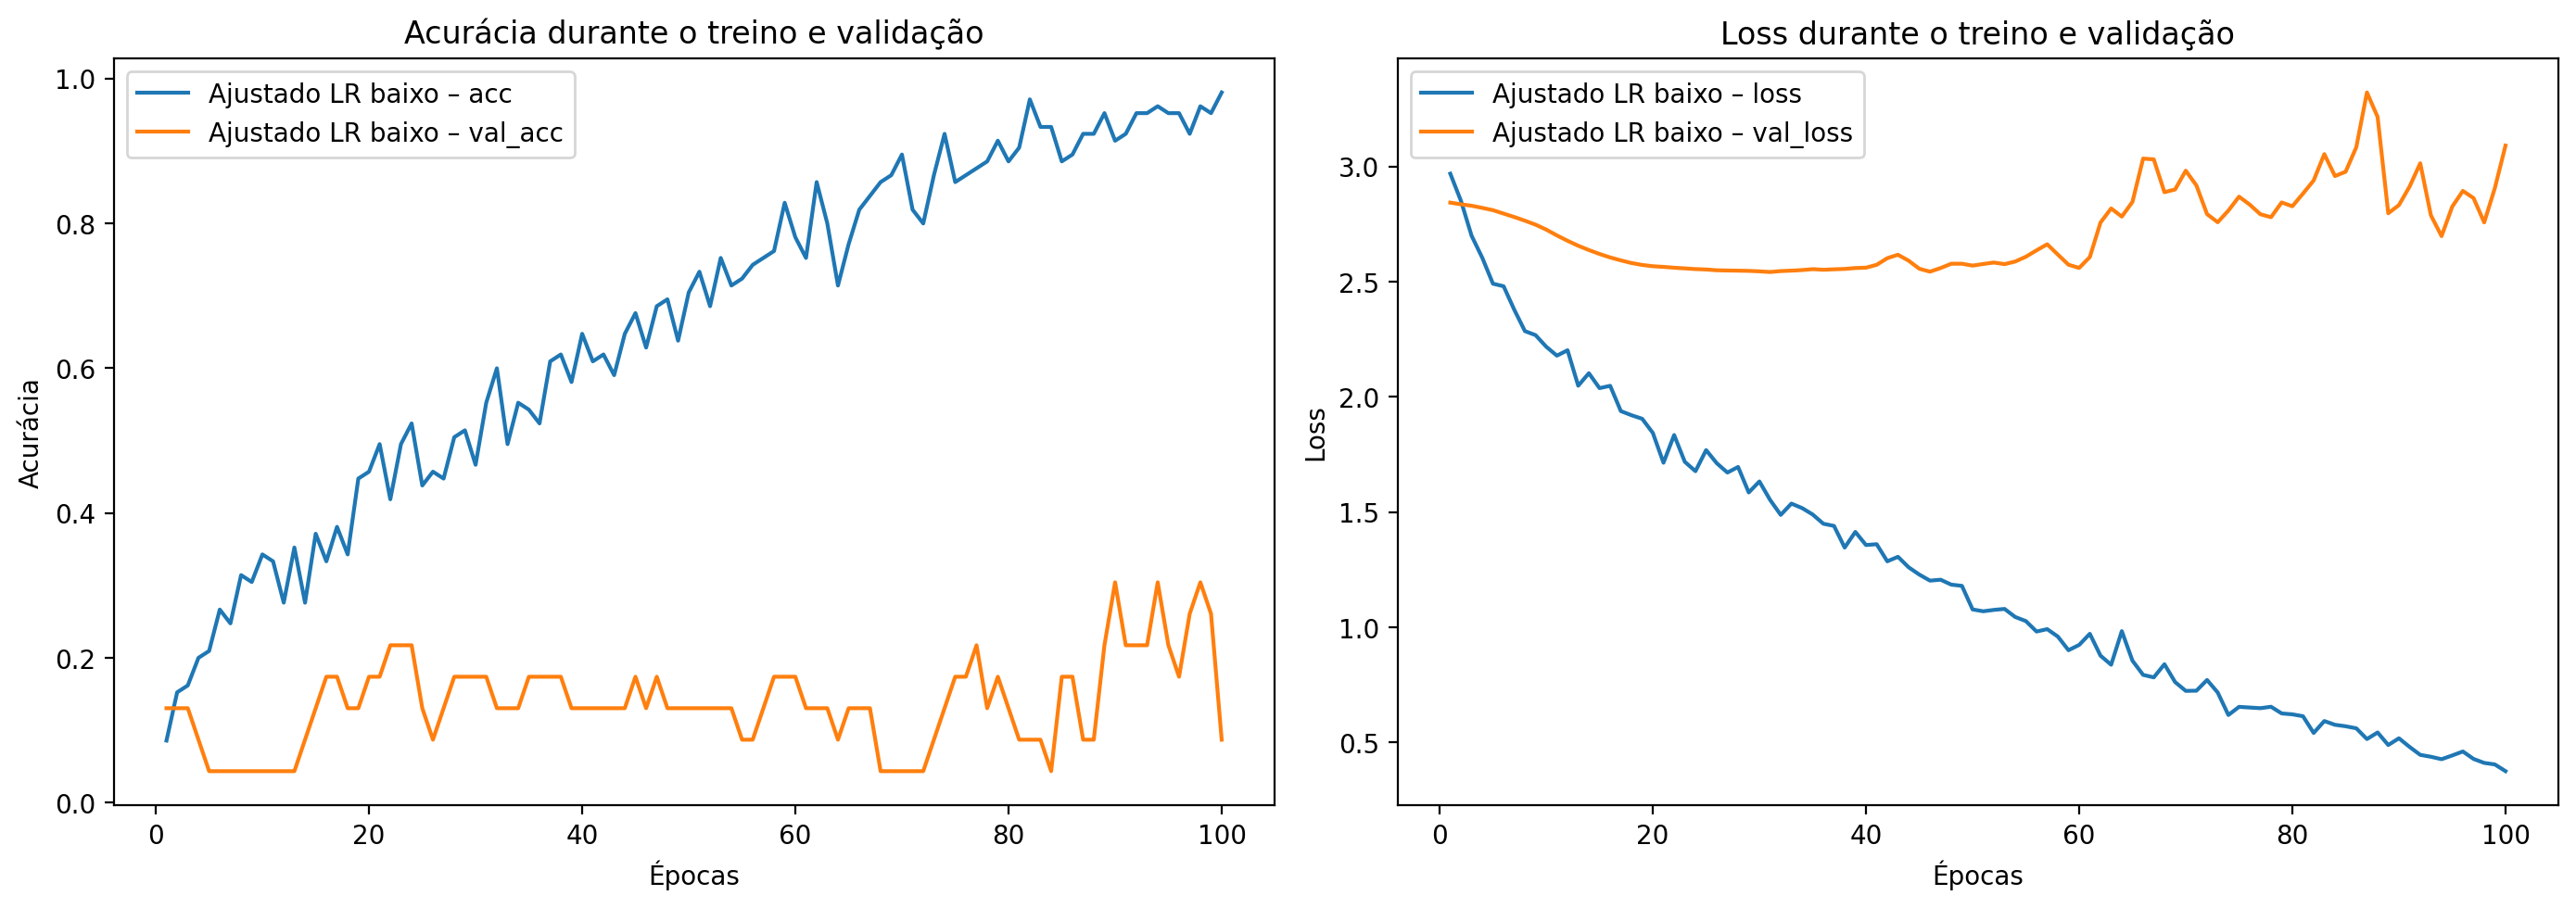

In [23]:
# Históricos de treino
hist2 = history_lr.history

epochs = range(1, len(hist2['loss']) + 1)

plt.figure(figsize=(14, 5))

# Curva de Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, hist2['loss'], label='Ajustado LR baixo – loss')
plt.plot(epochs, hist2['val_loss'], label='Ajustado LR baixo – val_loss')
plt.title('Loss durante o treino e validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

# Curva de Acurácia
plt.subplot(1, 2, 1)
plt.plot(epochs, hist2['accuracy'], label='Ajustado LR baixo – acc')
plt.plot(epochs, hist2['val_accuracy'], label='Ajustado LR baixo – val_acc')
plt.title('Acurácia durante o treino e validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()

### Impacto

No dataset em questão, não houve impacto. Houve overfitting da mesma forma e acurácia dentro do range dos modelos já treinados (simples e ajustado)

### 5.2. Explorar outras técnicas

Redes pré‑treinadas: utilizar um backbone pré‑treinado (como MobileNetV2 ou EfficientNet) e adicionar um head de classificação para suas 17 classes. Mesmo com imagens pequenas, redes pré‑treinadas em ImageNet costumam capturar padrões úteis e podem proporcionar saltos significativos de acurácia. Você teria que redimensionar as imagens para o tamanho esperado pelo modelo pré‑treinado (por exemplo, 96×96 ou 224×224) ou escolher uma versão “small”.

In [24]:
# Baixa o modelo pré-treinado
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(64, 64, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # congela todas as camadas da base

# Define o novo modelo
inputs = tf.keras.Input(shape=(64, 64, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

transfer_model = tf.keras.Model(inputs, outputs)

transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Treina apenas o cabeçalho customizado (base congelada)
history_mn = transfer_model.fit(
    train_mn,    
    validation_data=val_mn,  
    epochs=10
)

# Avalia no conjunto de teste
test_loss_mn, test_acc_mn = transfer_model.evaluate(test_mn) 
print(f"Acurácia com MobileNetV2 + head customizado: {test_acc_mn:.4f}")


/tmp/ipykernel_121748/3563482189.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 809ms/step - accuracy: 0.0820 - loss: 3.9707 - val_accuracy: 0.1304 - val_loss: 2.9274
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.1843 - loss: 2.6793 - val_accuracy: 0.1304 - val_loss: 3.0388
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.1831 - loss: 2.7397 - val_accuracy: 0.0870 - val_loss: 2.9022
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.2115 - loss: 2.6547 - val_accuracy: 0.1304 - val_loss: 2.6843
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.1883 - loss: 2.6184 - val_accuracy: 0.0435 - val_loss: 2.5226
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.1895 - loss: 2.6087 - val_accuracy: 0.1304 - val_loss: 2.5554
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.1999 - loss: 2.5792 - val_accuracy: 0.1304 - val_loss: 2.5490
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1947 - loss: 2.5550 - val_accuracy: 0.1304 - val_loss: 2.53

In [25]:
# Carrega a base ResNet50 sem o topo e congela
base_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Constrói o modelo de transferência
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
transfer_model = tf.keras.Model(inputs, outputs)

# Compila
transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Treina apenas a "cabeça" (base congelada)
history_resnet = transfer_model.fit(
    train_ds_resnet,
    validation_data=val_ds_resnet,
    epochs=10
)

# Avalia no teste
test_loss_resnet, test_acc_resnet = transfer_model.evaluate(test_ds_resnet)
print(f"Acurácia com ResNet50 + head customizado: {test_acc_resnet:.4f}")


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.1179 - loss: 2.8943 - val_accuracy: 0.1304 - val_loss: 2.6764
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.1426 - loss: 2.6165 - val_accuracy: 0.1739 - val_loss: 2.5380
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2779 - loss: 2.4923 - val_accuracy: 0.1304 - val_loss: 2.5555
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2054 - loss: 2.4802 - val_accuracy: 0.1304 - val_loss: 2.5319
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.1887 - loss: 2.4758 - val_accuracy: 0.1304 - val_loss: 2.4665
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.1887 - loss: 2.4906 - val_accuracy: 0.1304 - val_loss: 2.4424
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2602 - loss: 2.4624 - val_accuracy: 0.1304 - val_loss: 2.4955
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.1731 - loss: 2.4597 - val_accuracy: 0.1304 - val_loss: 2.5034
Epoch 9/10
4/4

In [26]:
# Carrega VGG16 sem topo, entrada 224×224, pesos ImageNet
base_model = VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # congela as camadas pré-treinadas

# Define a cabeça customizada
inputs = tf.keras.Input(shape=(224, 224, 3))
x = vgg16.preprocess_input(inputs)        
x = base_model(x, training=False)         
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
transfer_model = tf.keras.Model(inputs, outputs)

transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Treina só a cabeça, com os pipelines para VGG16
history_vgg = transfer_model.fit(
    train_vgg,      
    validation_data=val_vgg,  
    epochs=10
)

# Avalia no teste
test_loss_vgg, test_acc_vgg = transfer_model.evaluate(test_vgg)
print(f"Acurácia com VGG16 + head customizado: {test_acc_vgg:.4f}")


Epoch 1/10


2025-07-28 00:49:20.635953: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2025-07-28 00:49:20.685871: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


1/4 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.0312 - loss: 4.5610

2025-07-28 00:49:24.457900: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2025-07-28 00:49:24.553025: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


2/4 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.0469 - loss: 4.4218 

2025-07-28 00:49:28.377328: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.0423 - loss: 4.2307 - val_accuracy: 0.0000e+00 - val_loss: 3.4363
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.0551 - loss: 3.3215 - val_accuracy: 0.0000e+00 - val_loss: 2.8917
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.0794 - loss: 2.8325 - val_accuracy: 0.1304 - val_loss: 2.6967
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.2054 - loss: 2.5994 - val_accuracy: 0.1304 - val_loss: 2.6700
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.1908 - loss: 2.5872 - val_accuracy: 0.1304 - val_loss: 2.5794
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.1876 - loss: 2.5604 - val_accuracy: 0.1304 - val_loss: 2.5038
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.1814 - loss: 2.5166 - val_accuracy: 0.1304 - val_loss: 2.4709
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.1471 - loss: 2.5330 - val_accuracy: 0.1304 - val_loss: 2.4560
Epoch 9/10


In [27]:
# Carrega a base EfficientNetB0 sem topo
base_model = EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # congela a base

# Define a cabeça customizada
inputs = tf.keras.Input(shape=(224, 224, 3))
x = efficientnet.preprocess_input(inputs)   
x = base_model(x, training=False)          
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
transfer_model = tf.keras.Model(inputs, outputs)

transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Treina apenas o cabeçalho customizado
history_efn = transfer_model.fit(
    train_efn,     
    validation_data=val_efn, 
    epochs=10
)

# Avalia no conjunto de teste
test_loss_efn, test_acc_efn = transfer_model.evaluate(test_efn)
print(f"Acurácia com EfficientNetB0 + head customizado: {test_acc_efn:.4f}")

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.1179 - loss: 2.8329 - val_accuracy: 0.1304 - val_loss: 2.6032
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.1630 - loss: 2.5989 - val_accuracy: 0.1304 - val_loss: 2.5747
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2168 - loss: 2.5221 - val_accuracy: 0.1304 - val_loss: 2.5908
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 973ms/step - accuracy: 0.2054 - loss: 2.5262 - val_accuracy: 0.1304 - val_loss: 2.5815
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.1731 - loss: 2.5348 - val_accuracy: 0.1304 - val_loss: 2.5044
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.1481 - loss: 2.5405 - val_accuracy: 0.1304 - val_loss: 2.4725
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2054 - loss: 2.5171 - val_accuracy: 0.1304 - val_loss: 2.4711
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.1731 - loss: 2.5223 - val_accuracy: 0.1304 - val_loss: 2.4858
Epoch 9/10
4

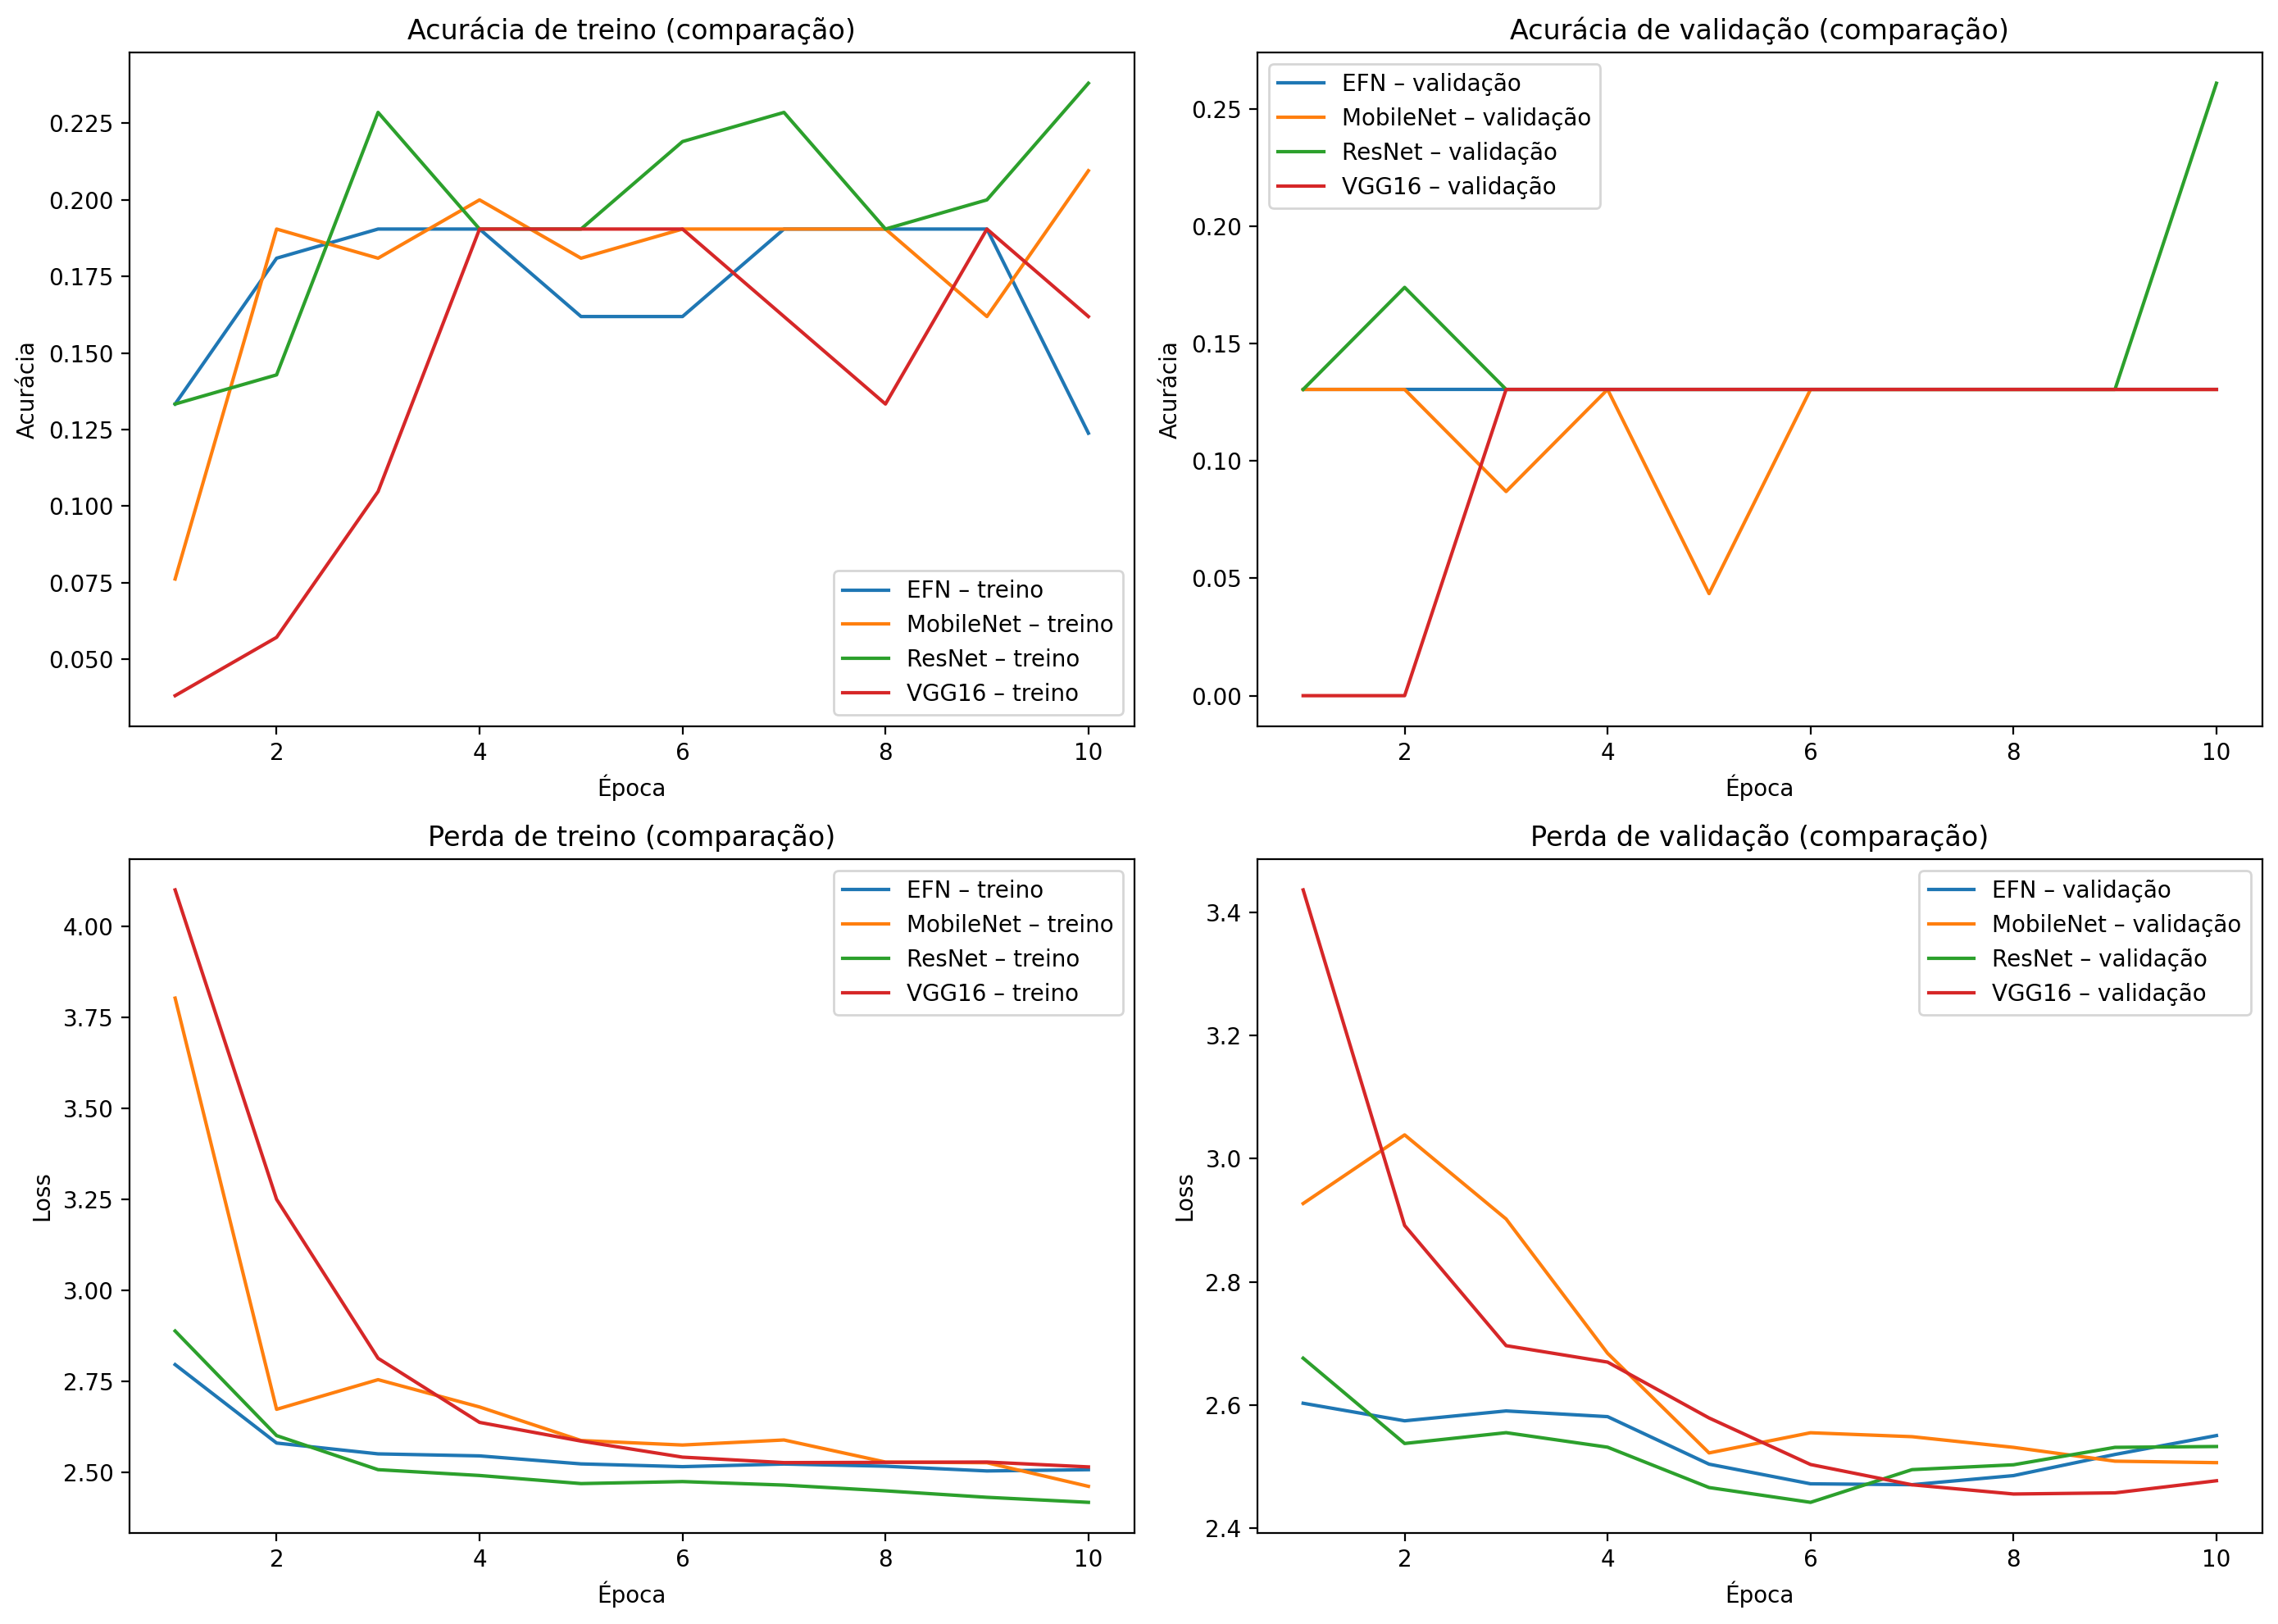

In [28]:
# Recupera as métricas do histórico de cada modelo
simple_hist   = simple_history.history
adjusted_hist = adjusted_history.history
efn_hist = history_efn.history
mn_hist = history_mn.history
resnet_hist = history_resnet.history
vgg_hist = history_vgg.history

epochs_range = range(1, len(simple_hist['loss']) + 1)

plt.figure(figsize=(14, 10))

# Gráfico de acurácia - treino
plt.subplot(2, 2, 1)
plt.plot(epochs_range, efn_hist['accuracy'],     label='EFN – treino')
plt.plot(epochs_range, mn_hist['accuracy'],     label='MobileNet – treino')
plt.plot(epochs_range, resnet_hist['accuracy'],     label='ResNet – treino')
plt.plot(epochs_range, vgg_hist['accuracy'],     label='VGG16 – treino')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.title('Acurácia de treino (comparação)')
plt.legend()

# Gráfico de acurácia - validação
plt.subplot(2, 2, 2)
plt.plot(epochs_range, efn_hist['val_accuracy'], label='EFN – validação')
plt.plot(epochs_range, mn_hist['val_accuracy'], label='MobileNet – validação')
plt.plot(epochs_range, resnet_hist['val_accuracy'], label='ResNet – validação')
plt.plot(epochs_range, vgg_hist['val_accuracy'], label='VGG16 – validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.title('Acurácia de validação (comparação)')
plt.legend()

# Gráfico de perda (loss) - treino
plt.subplot(2, 2, 3)
plt.plot(epochs_range, efn_hist['loss'],     label='EFN – treino')
plt.plot(epochs_range, mn_hist['loss'],     label='MobileNet – treino')
plt.plot(epochs_range, resnet_hist['loss'],     label='ResNet – treino')
plt.plot(epochs_range, vgg_hist['loss'],     label='VGG16 – treino')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Perda de treino (comparação)')
plt.legend()

# Gráfico de perda (loss) - validação
plt.subplot(2, 2, 4)
plt.plot(epochs_range, efn_hist['val_loss'], label='EFN – validação')
plt.plot(epochs_range, mn_hist['val_loss'], label='MobileNet – validação')
plt.plot(epochs_range, resnet_hist['val_loss'], label='ResNet – validação')
plt.plot(epochs_range, vgg_hist['val_loss'], label='VGG16 – validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Perda de validação (comparação)')
plt.legend()


plt.tight_layout()
plt.show()

## 6. Discussão técnica
- Aponte erros comuns (overfitting, normalização insuficiente).
  - O erro mais comum foi de overfitting. Os modelos apresentavam uma acurácia significante no passo do treino, mas a perdiam na fase de teste. Isso mostra que o modelo aprendia próximo aos seus dados de treinamento, não conseguindo, portanto, generalizar de maneira satisfatória para novos dados.

- Limitações (tamanho do dataset, classes desequilibradas).
  - O dataset possui um problema complexo: as características visuais da amostra não são diretamente relacionadas com o tipo do Pokémon em questão. Logo, seria difícil até para um ser humano acertar a classe apresentada apenas pela imagem.

- Melhorias (data augmentation, arquiteturas mais profundas).
  - Apesar de serem melhorias, tanto o data augmentation quanto as arquiteturas consolidadas não foram capazes de melhorar a acurácia dos modelos. Provavelmente pelo motivo citado acima.
  - Alguns Pokémons possuem dois tipos. Fazer uma combinação dos dois tipos poderia aumentar os acertos do modelo.
      - Por exemplo: o Pokémon Articuno possui asas, mas seu tipo 1 é Gelo (Ice) e seu tipo 2 é Voador (Flying). Se fossemos generalizar para tem asas -> voador, então o modelo poderia acertar, mas pegando apenas o tipo 1, ele erraria nesses casos.

## Contribuições
- Rodrigo: dataset, pré-processamento.

- Clara: arquitetura e treino.

- Ryan: avaliação e análise.